In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Lambda, Dropout, Dense, Flatten
from tensorflow.keras.regularizers import l2

from utils import INPUT_SHAPE, batch_generator

(array([   51.,   143.,   444.,   593.,   468., 11034.,    93.,    48.,
           39.,    31.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

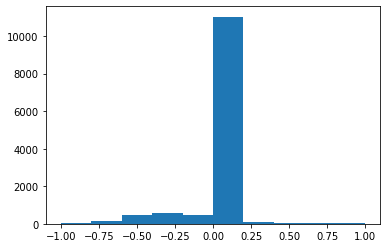

In [9]:
# Read file driving_log.csv with corresponding columns
data_df = pd.read_csv('driving_log.csv', names=['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed'])

# Take the access to center, left, right camera
X = data_df[['center', 'left', 'right']].values
# Take the steering angle
y = data_df['steering'].values

# Draw data histogram
plt.hist(y)

(array([  51.,  143.,  444.,  593.,  468., 1106.,   93.,   48.,   39.,
          31.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

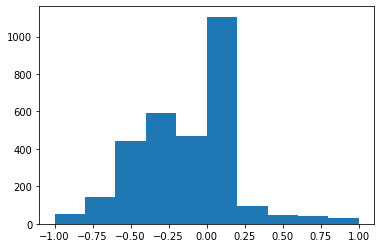

In [10]:
# Eliminate and take only 1000 data at angle 0
pos_zero = np.array(np.where(y==0)).reshape(-1,1)
pos_non_zero = np.array(np.where(y!=0)).reshape(-1,1)
np.random.shuffle(pos_zero)
pos_zero = pos_zero[:1000]

pos_combined = np.vstack((pos_zero, pos_non_zero))
pos_combined = list(pos_combined)

y = y[pos_combined].reshape(len(pos_combined))
X = X[pos_combined, :].reshape((len(pos_combined), 3))

# After process
plt.hist(y)

In [11]:
# Train-test sets split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0)

In [18]:
# Build model
model = Sequential()
model.add(Lambda(lambda x: x/127.5-1.0, input_shape=INPUT_SHAPE))
model.add(Conv2D(24, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(36, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(48, (5, 5), activation='elu', strides=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Conv2D(64, (3, 3), activation='elu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(100, activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(50, activation='elu'))
model.add(Dense(10, activation='elu'))
model.add(Dense(1))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 66, 200, 3)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 18, 64)        

In [27]:
nb_epoch = 10
samples_per_epoch = 1000
batch_size = 32
save_best_only = True
learning_rate = 1e-4
data_dir = 'c:/users/my laptop/desktop/deep learning with tf - keras/beta_simulator_windows'

# Checkpoint 
checkpoint = ModelCheckpoint('model.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=save_best_only,
                                 mode='auto')

# Use mean_squrared_error as loss function
model.compile(loss='mean_squared_error', 
              optimizer=keras.optimizers.Adam(lr=learning_rate))

# Train model
H = model.fit_generator(batch_generator(data_dir, X_train, y_train, batch_size, True),
                    steps_per_epoch = samples_per_epoch,
                    epochs = nb_epoch,
                    max_queue_size=1,
                    validation_data=batch_generator(data_dir, X_valid, y_valid, batch_size, False),
                    callbacks=[checkpoint],
                    validation_steps = int(len(X_valid)/batch_size),
                    verbose=1)

Epoch 1/10
1000/1000 [==============================] - 116s 116ms/step - loss: 0.0597 - val_loss: 0.0584
Epoch 2/10
1000/1000 [==============================] - 114s 114ms/step - loss: 0.0584 - val_loss: 0.0522
Epoch 3/10
1000/1000 [==============================] - 116s 116ms/step - loss: 0.0567 - val_loss: 0.0525
Epoch 4/10
1000/1000 [==============================] - 115s 115ms/step - loss: 0.0545 - val_loss: 0.0534
Epoch 5/10
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0550 - val_loss: 0.0541
Epoch 6/10
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0535 - val_loss: 0.0512
Epoch 7/10
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0521 - val_loss: 0.0544
Epoch 8/10
1000/1000 [==============================] - 117s 117ms/step - loss: 0.0509 - val_loss: 0.0474
Epoch 9/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0518 - val_loss: 0.0540
Epoch 10/10
1000/1000 [=======================